In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox

from itertools import product
from numpy.linalg import LinAlgError

In [3]:
df = pd.read_csv('database.csv',  header = None)
df.head(3)

,0,1,2,3,4,5,6,7
0,NaN,0,1.00,2.00,3.00,4.00,5,6
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,"May 28, 2019",8802.76,8807.02,8634.72,8719.96,"24,226,919,267","154,590,202,287"


In [4]:
df.columns = ['0','Date', 'Open', 'High', "Low", "Close", "Volume", "Market_cap"]

In [6]:
df.drop(df.index[0], inplace = True)

In [7]:
df.head()

,0,Date,Open,High,Low,Close,Volume,Market_cap
2,1.0,"May 28, 2019",8802.76,8807.02,8634.72,8719.96,"24,226,919,267","154,590,202,287"
3,2.0,"May 27, 2019",8674.07,8907.17,8668.70,8805.78,"27,949,839,564","156,093,754,762"
4,3.0,"May 26, 2019",8055.21,8687.52,7924.67,8673.22,"26,677,970,091","153,725,486,067"
5,4.0,"May 25, 2019",7991.89,8117.93,7965.98,8052.54,"22,256,813,107","142,708,188,838"
6,5.0,"May 24, 2019",7881.70,8140.72,7824.45,7987.37,"25,919,126,991","141,539,115,575"


In [8]:
df.drop(columns = ['0'], inplace = True)
df.head()

,Date,Open,High,Low,Close,Volume,Market_cap
2,"May 28, 2019",8802.76,8807.02,8634.72,8719.96,"24,226,919,267","154,590,202,287"
3,"May 27, 2019",8674.07,8907.17,8668.70,8805.78,"27,949,839,564","156,093,754,762"
4,"May 26, 2019",8055.21,8687.52,7924.67,8673.22,"26,677,970,091","153,725,486,067"
5,"May 25, 2019",7991.89,8117.93,7965.98,8052.54,"22,256,813,107","142,708,188,838"
6,"May 24, 2019",7881.70,8140.72,7824.45,7987.37,"25,919,126,991","141,539,115,575"


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [10]:
df.sort_index(inplace = True)

In [11]:
df.head()

,Open,High,Low,Close,Volume,Market_cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,488,566,728"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,603,768,865"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,542,813,125"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,298,954,594"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,168,517,495"


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2222 entries, 2013-04-28 to 2019-05-28
Data columns (total 6 columns):
Open          2222 non-null float64
High          2222 non-null float64
Low           2222 non-null float64
Close         2222 non-null float64
Volume        2222 non-null object
Market_cap    2222 non-null object
dtypes: float64(4), object(2)
memory usage: 121.5+ KB


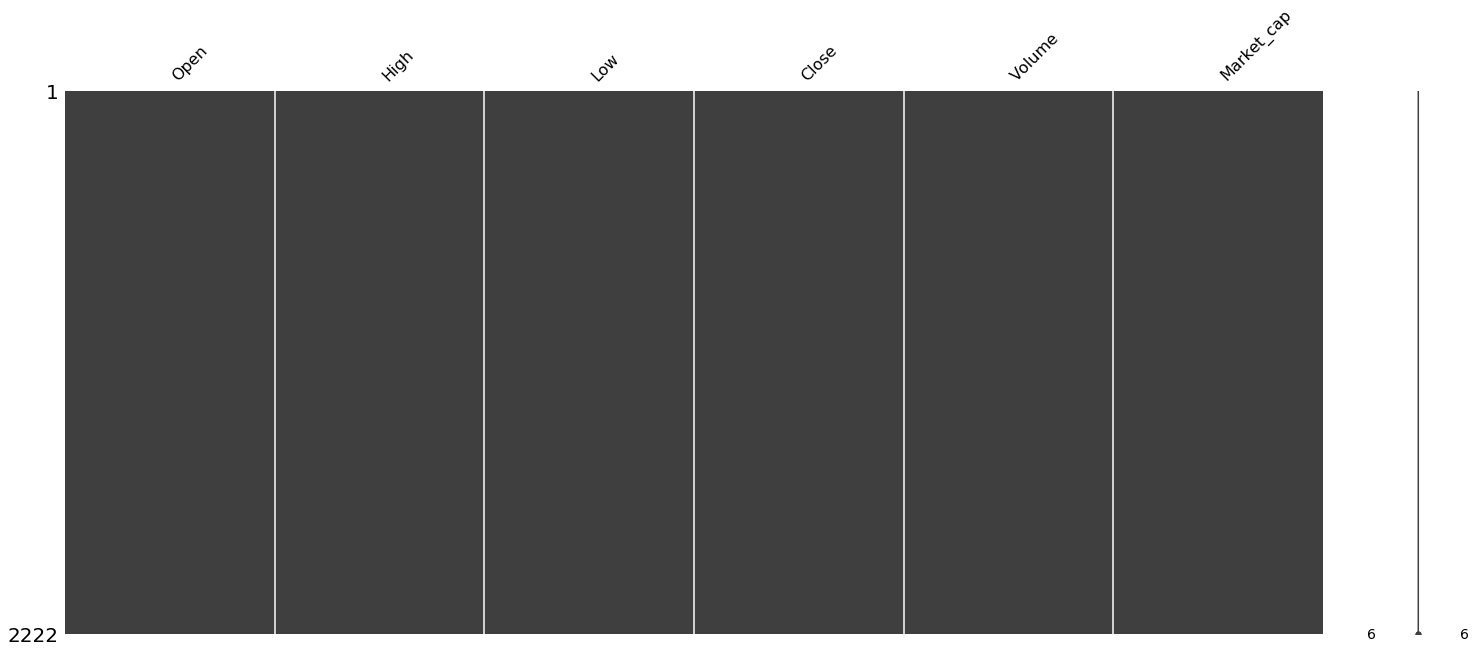

In [13]:
import missingno as msno 
msno.matrix(df);

In [14]:
df.shape

(2222, 6)

In [15]:
df.describe()

,Open,High,Low,Close
count,2222.000000,2222.000000,2222.000000,2222.000000
mean,2466.245171,2538.163209,2388.697061,2469.955441
std,3372.343769,3493.769913,3228.225726,3374.399363
min,68.500000,74.560000,65.530000,68.430000
25%,350.962500,359.300000,343.142500,351.045000
50%,631.895000,644.960000,620.715000,632.465000
75%,3915.577500,4009.142500,3851.505000,3924.257500
max,19475.800000,20089.000000,18974.100000,19497.400000


In [18]:
df_closing = df.Close

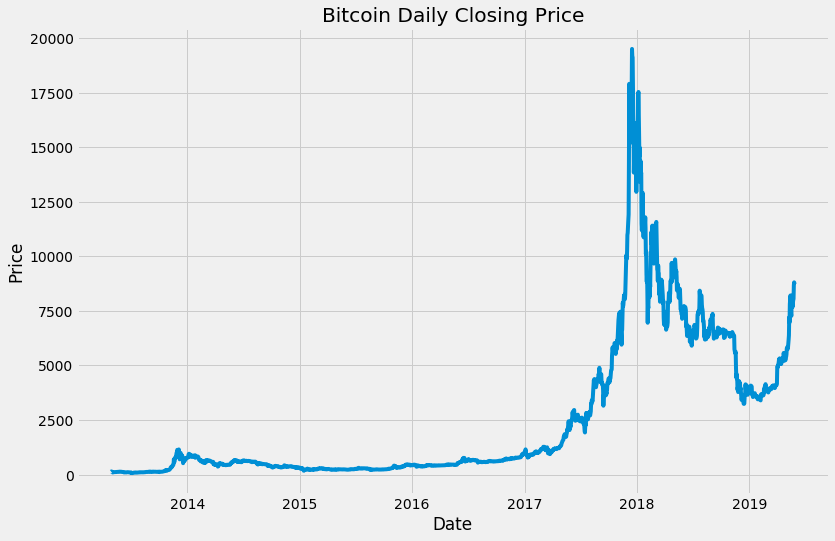

In [19]:
plt.style.use('fivethirtyeight')
ax = df_closing.plot(figsize = (12,8), title = "Bitcoin Daily Closing Price", fontsize = 14);
ax.set_ylabel('Price')
plt.show()

In [20]:
# monthly resmapling 
df_closing = df_closing.resample('M').mean()

In [21]:
df_closing.head()

Date
2013-04-30    139.250000
2013-05-31    119.992581
2013-06-30    107.761333
2013-07-31     90.512258
2013-08-31    113.905161
Freq: M, Name: Close, dtype: float64

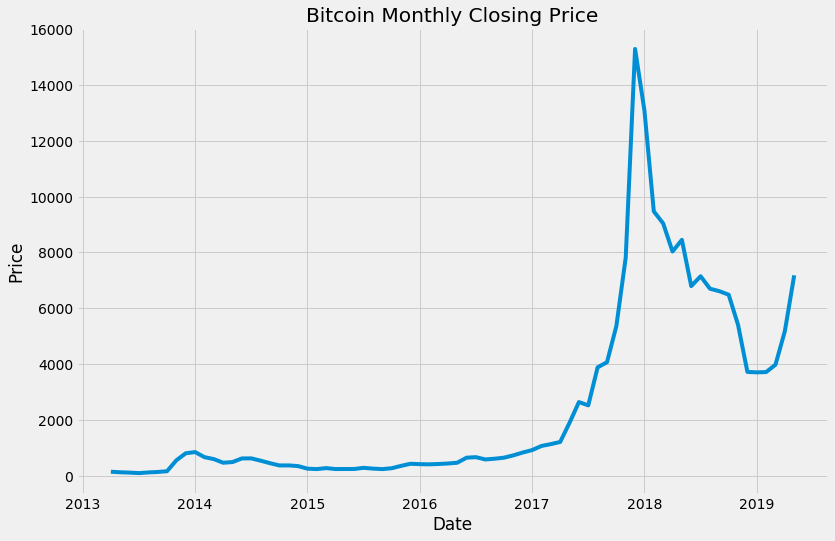

In [23]:
# plotting monthly 
ax = df_closing.plot(figsize = (12,8), title = "Bitcoin Monthly Closing Price", fontsize = 14);
ax.set_ylabel('Price')
plt.show()

<Figure size 432x288 with 0 Axes>

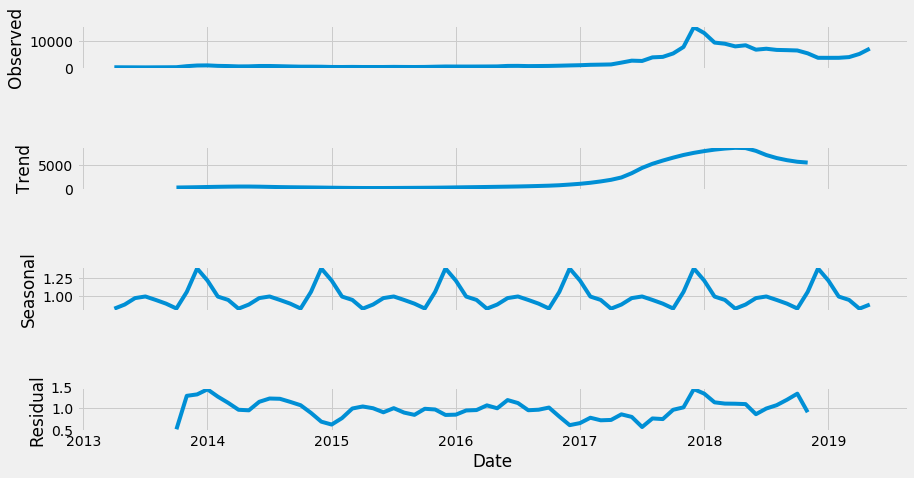

In [24]:
# assesssing components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_closing, model = "multiplicative") #mulitiplicative
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [25]:
def plots(series):
    plt.figure(figsize = (10,6))
    sns.lineplot(data = series, color = 'blue', label = 'observed line plot')
    sns.lineplot(data = series.rolling(window = 12).mean(), color = 'green', label = 'rolling mean, window -12')
    sns.lineplot(data = series.rolling(window = 12).std(), color = 'black', label = 'std deviation, window -12')

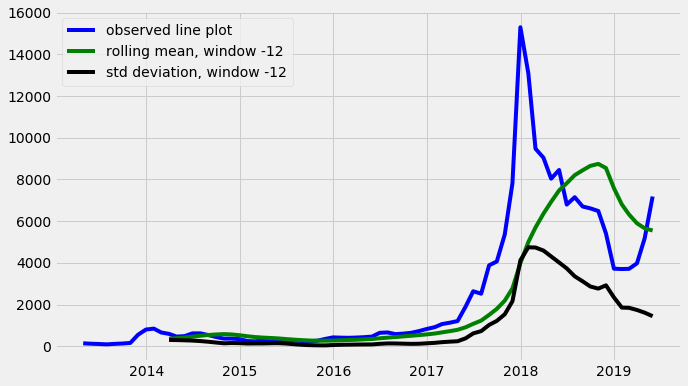

In [26]:
plots(df_closing)

# Trasnformation

## Log

<Figure size 432x288 with 0 Axes>

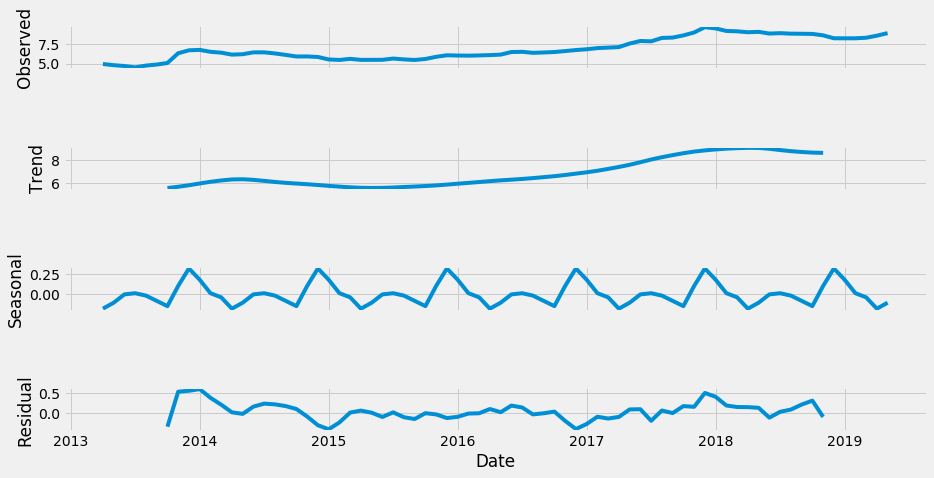

In [72]:
price_log = np.log(df_closing)

decomposition = seasonal_decompose(price_log)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

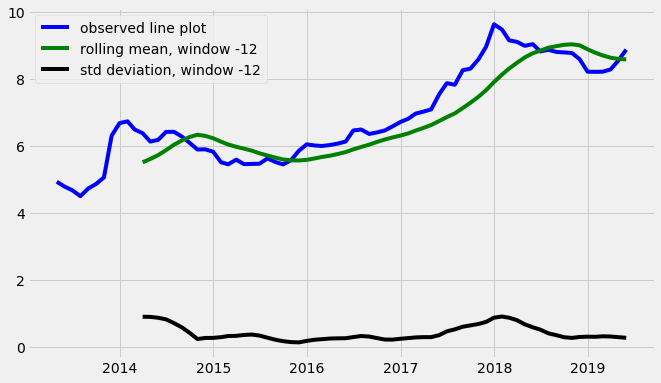

In [73]:
plots(price_log);

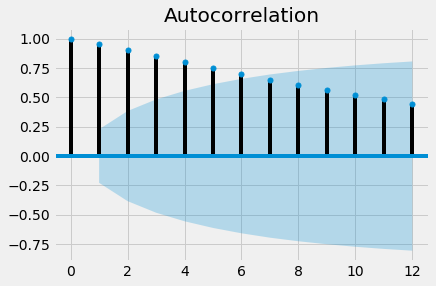

In [76]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(price_log, lags = 12)

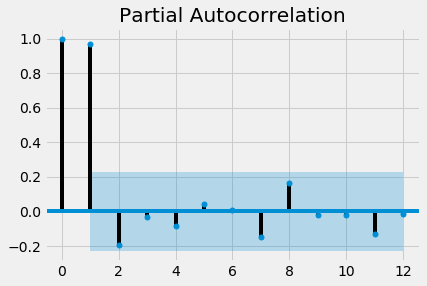

In [78]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_pacf(price_log, lags = 12)

## Timeshift to log

In [39]:
prices_log_r = price_log - price_log.shift(1)
prices_log_r.dropna(inplace = True)

<Figure size 432x288 with 0 Axes>

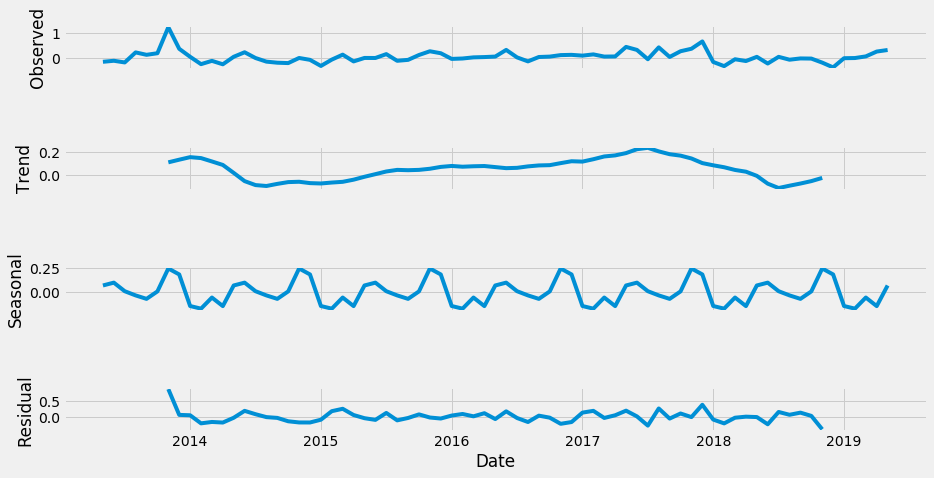

In [41]:
decomposition = seasonal_decompose(prices_log_r)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

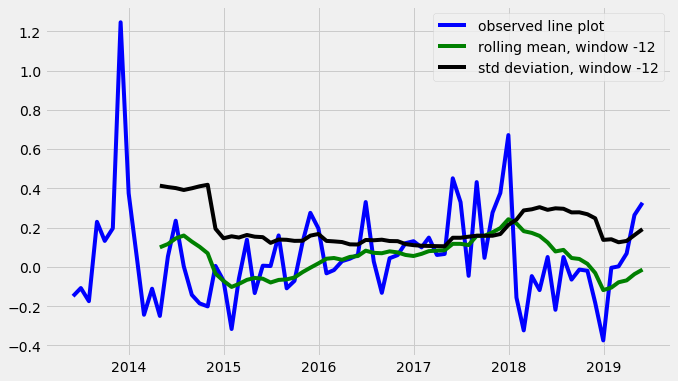

In [42]:
plots(prices_log_r);

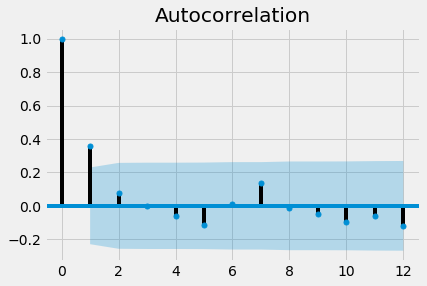

In [74]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(prices_log_r, lags = 12)

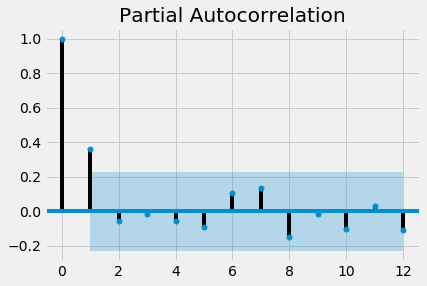

In [75]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_pacf(prices_log_r, lags = 12)

## Test for stationarity

In [45]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

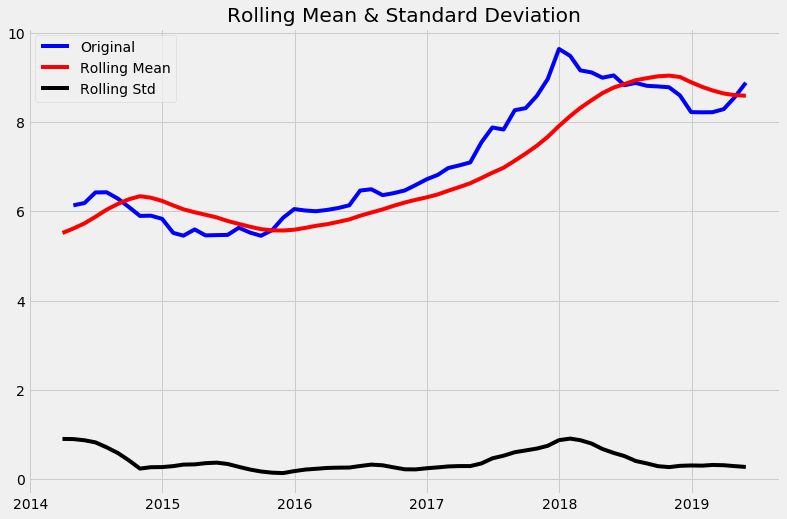

Results of Dickey-Fuller Test:
Test Statistic                 -1.111881
p-value                         0.710311
#Lags Used                      1.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [98]:
test_stationarity(price_log, 12)

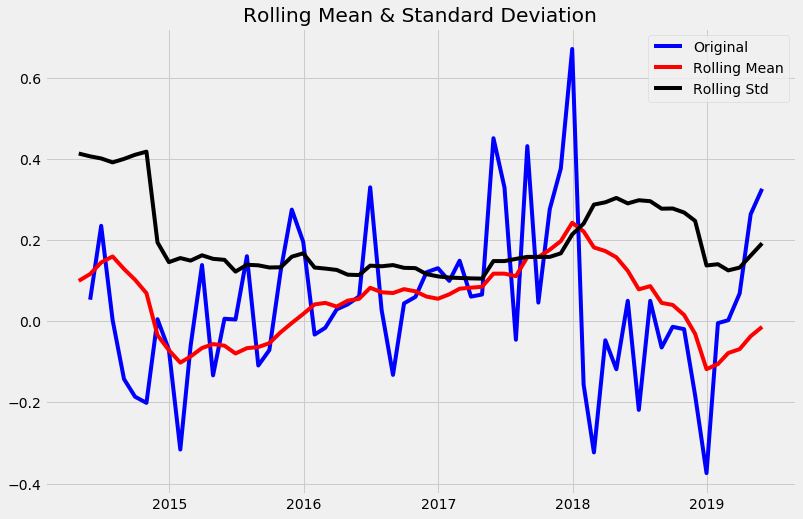

Results of Dickey-Fuller Test:
Test Statistic                -5.693745e+00
p-value                        7.961357e-07
#Lags Used                     0.000000e+00
Number of Observations Used    7.200000e+01
Critical Value (1%)           -3.524624e+00
Critical Value (5%)           -2.902607e+00
Critical Value (10%)          -2.588679e+00
dtype: float64


In [46]:
test_stationarity(prices_log_r, 12)

## Additional test for random walk

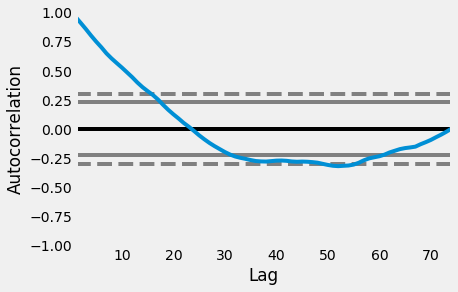

In [105]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(price_log)
plt.show()

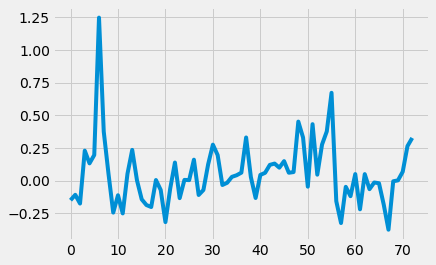

In [106]:
# take difference
diff = list()
for i in range(1, len(price_log)):
    value = price_log[i] - price_log[i - 1]
    diff.append(value)
# line plot
plt.plot(diff)
plt.show()

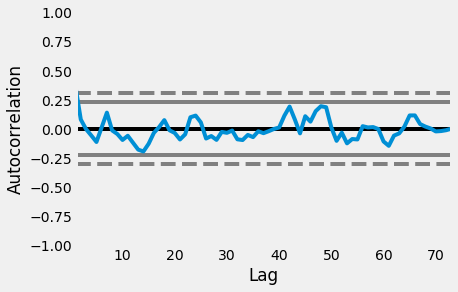

In [107]:
# line plot
autocorrelation_plot(diff)
plt.show()

In [108]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Run the ADF test on the price series and print out the results
results = adfuller(prices_log_r)
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-5.6937446187207055, 7.961357299916424e-07, 0, 72, {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}, -29.39455539245752)
The p-value of the test on prices is: 7.961357299916424e-07


## ARIMA

Rejected Parameters: (1, 1, 3)
Rejected Parameters: (2, 1, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1) -3.4202871671831474
[[(1, 1, 1), -3.4202871671831474], [(1, 1, 2), -1.4233721273368758], [(2, 1, 2), -2.347431212496417], [(2, 1, 3), 2.477788100606716], [(3, 1, 1), 0.5672161731263259], [(3, 1, 2), 1.3421737069686515], [(3, 1, 3), 1.475759997288634]]
Date
2013-05-31    0.054415
2013-06-30   -0.018932
2013-07-31    0.002897
2013-08-31   -0.025347
2013-09-30    0.131387
2013-10-31    0.073809
2013-11-30    0.105630
2013-12-31    0.498556
2014-01-31    0.116791
2014-02-28    0.045519
2014-03-31   -0.057196
2014-04-30    0.006682
2014-05-31   -0.054316
2014-06-30    0.068435
2014-07-31    0.121102
2014-08-31    0.026275
2014-09-30   -0.016263
2014-10-31   -0.027111
2014-11-30   -0.031394
2014-12-31    0.047225
2015-01-31    0.008201
2015-02-28   -0.079652
2015-03-31    0.028670
2015-04-30    0.089795
2015-05-31   -0.021266
2015-06-30    0.046271
2015-07-31    0.036631
2015-08-31    0.096960
2015-09-30   -0.013000
2015-10-31    0.015973
                ...   
2016-12-31    0.0794

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


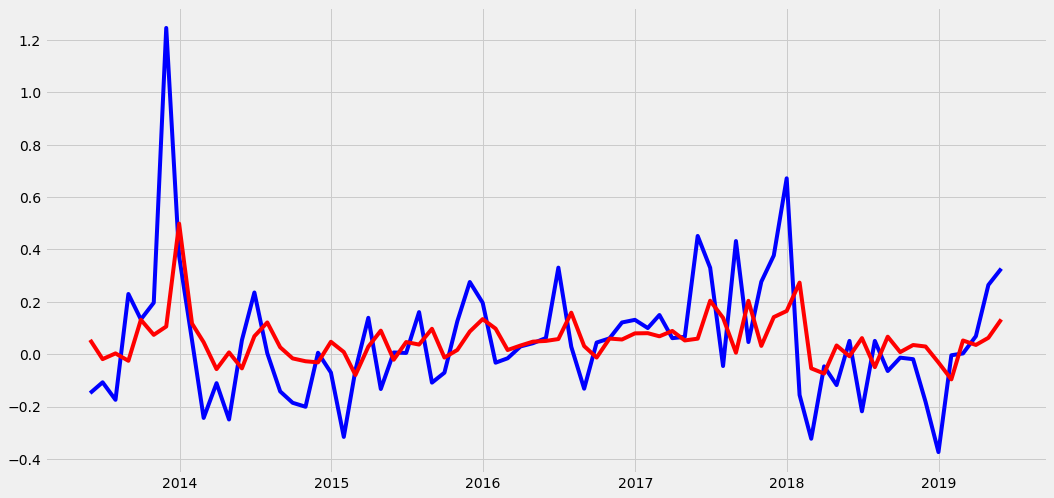

In [96]:
a = [[1,2,3], [1],[1,2,3]]
params = list(product(*a))

results = []   
min_aic = float('inf')
best_param = []

# checking different set of params for best fit
for param in params:
    try:
        model = ARIMA(price_log, order = param).fit(disp = -1)
    except LinAlgError:
        print('Rejected Parameters:', param)
        continue
    except ValueError:
        print('Rejected Parameters:', param)
        continue
    if(min_aic > model.aic):
        min_aic = model.aic
        best_param = param
        best_model = model
        
    results.append([param, model.aic])

print(best_param,min_aic)
print(results)

print(best_model.fittedvalues)

plt.figure(figsize=(16,8))
sns.lineplot(data = prices_log_r, color = 'blue')
sns.lineplot(data = best_model.fittedvalues, color = 'red')    

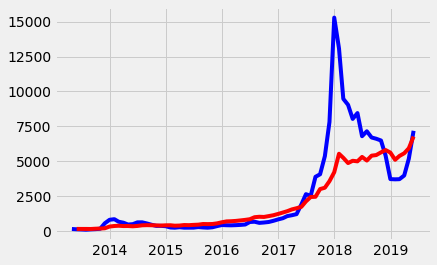

In [81]:
fitted_values = best_model.fittedvalues
fitted_values = fitted_values.cumsum()

fitted_values = fitted_values + price_log[0]

final_values = np.exp(fitted_values)

d = {'prices' : df_closing, 'prices_log' : price_log, 'price_log_r' : prices_log_r, 'fitted_values' : fitted_values, 'final_values' : final_values}
summaryDF = pd.DataFrame(data = d)
sns.lineplot(data = summaryDF['prices'], color = 'blue')
sns.lineplot(data = summaryDF['final_values'], color = 'red')

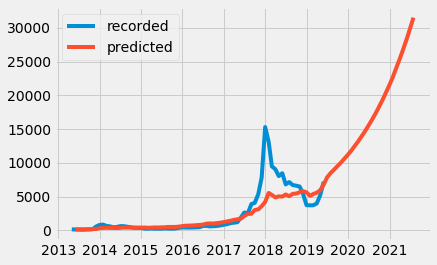

In [84]:
predicted_values = np.exp((best_model.predict(start = 1, end = 99).cumsum()) + price_log[0])
sns.lineplot(data = df_closing, label  = 'recorded')
sns.lineplot(data = predicted_values, label = 'predicted')

In [89]:
mod = ARIMA(price_log, order = (1,1,0))
res = mod.fit()
print(res.summary())
print(res.params)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   73
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   5.621
Method:                       css-mle   S.D. of innovations              0.224
Date:                Wed, 29 May 2019   AIC                             -5.242
Time:                        11:09:34   BIC                              1.629
Sample:                    05-31-2013   HQIC                            -2.504
                         - 05-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0545      0.041      1.340      0.184      -0.025       0.134
ar.L1.D.Close     0.3612      0.110      3.293      0.002       0.146       0.576
                                    Root

In [91]:
price_log.shape

(74,)

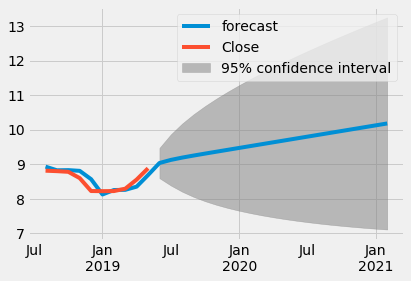

In [94]:
# plotting real vs predicted log
res.plot_predict(start = 64 , end = 94 )
plt.show()